## Guassian Process Regression

### Gaussian Distribution vs. Gaussian Process

Gaussian Distribution (Normal Distribution) describes the shape or probability of how data points in a dataset will be distributed, with the expression of: 

$$X \sim N(\mu, \Sigma)$$

Gaussian process a probability distribution over possible functions instead of data points. The idea is to model the unknown function that relates the input and output variables as a random draw from a Gaussian process. This allows us to make predictions on new input values by calculating the conditional distribution of the output variable given the input values and the training data. GP is fully expressed by its mean function and kernel function: 

$$X \sim GP(m(x),  k(x,x'))$$

$m(x)$: the mean function, describes the mean of any given data point x
$k(x,x')$: the kernel function, describes the relationship between any given two data points x and x'.

Kernel function: defines the covariance between different points in the input space, which determines how closely related these points are in terms of their output values. 

The most common kernel function is the radial basis function (RBF) kernel: 

$$k(x1, x2) = exp-\dfrac{(x1 - x2)^2}{2L^2}$$

One advantage of Gaussian regression is that it provides a probabilistic estimate of the predicted output, along with a measure of uncertainty. This is in contrast to other regression techniques, such as linear regression or decision trees, which only provide a point estimate of the predicted output. Additionally, Gaussian regression can be used for tasks such as Bayesian optimization, where the goal is to find the input values that maximize a given objective function.

/home/922361294/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Text(0, 0.5, 'Predicted')

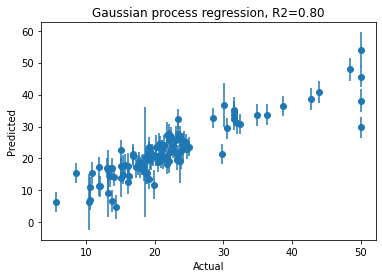

In [7]:
# GPR example using scikit-learn packages:
# reference: https://towardsdatascience.com/getting-started-with-gaussian-process-regression-modeling-47e7982b534d 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
import matplotlib.pyplot as plt

X, y = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# use a combined kernel
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10) + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)
y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)

plt.figure()
plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
plt.title('Gaussian process regression, R2=%.2f' % r2_score(y_test, y_pred_te))
plt.xlabel('Actual')
plt.ylabel('Predicted')


Fit a GP to data:
 
$$ \hat{y} = \mu(X_*) + K_{*X} (K_{XX} + \sigma^2 I)^{-1} (y_{X} - \mu(X)) $$

$K_{*X}$ is the covariance matrix between test and training data, $K_{XX}$ is the covariance matrix between training and training data, $y_X$ is the predictive output from the training dataset.

In [8]:
# write my own kernel and GP model
import cupy as cp
import matplotlib.pyplot as plt

# Radial basis function (RBF) kernel
def RBF(x1, x2, length_scale=1.0):
    x1=cp.array(x1)
    x2=cp.array(x2)
    return cp.exp(-0.5 * (x1 - x2)**2 / length_scale ** 2)
'''
x1 = [[1,1,1],[2,2,2],[3,3,3]]
x2 = [[4,5,6], [4,5,6], [4,5,6]]
y = RBF(x1, x2)
print(y)
'''

# kernel/covariance matrix
def kernel_matrix(kernel, X1, X2, L=1.0, sigma=1e-6):
    # let's first assum X1 and X2 are both one-dimensional
    size1 = X1.shape[0]
    size2 = X2.shape[0]
    X1 = cp.reshape(X1, [size1,1])
    X2 = cp.reshape(X2, [1, size2])
    m = X1.shape[0]
    n = X2.shape[1]
    X1_trans = cp.repeat(X1, n, axis=1)
    X2_trans = cp.repeat(X2, m, axis=0) 
    #print(X1_trans)
    #print(X2_trans)
    return kernel(X1,X2,L)

def mu(x):
    return x

def GP_fit_predict(x_train, x_test, y_train, y_test, k, mu, kernel_matrix, L = 1.0, sigma = 1e-6):
    # GP_fit with this function:
    # y = mu(X_*) + K_{*X} (K_{XX} + \sigma^2 I)^{-1} (y_{X} - \mu(X))
    
    K_train_test = kernel_matrix(k, x_test, x_train, L, sigma)
    K_train_train = kernel_matrix(k, x_train, x_train, L, sigma)

    K_y = cp.linalg.inv(K_train_train - (sigma * cp.identity(x_train.shape[0]) ))
    post_mean = mu(x_test) + ( (K_train_test @ K_y) @ (y_train - mu(x_train)) )
    return post_mean

'''
x1 = cp.array([1,2,3,4])
x2 = cp.array([5,6])
kernel_mat = kernel_matrix(RBF, x1, x2)
print(kernel_mat)
'''

X_train = cp.array([1., 7., 4.])
X_test = cp.array([2.5, 5.3])

y_train = cp.array([1.4,0.6,9.4])
y_test = cp.array([4.,1.])

# use the same dataset for both training and testing
post_mean = GP_fit_predict(X_train, X_train, y_train, y_train, RBF, mu, kernel_matrix)
print(post_mean)
print(y_train)



[1.40000034 0.59999354 9.40000547]
[1.4 0.6 9.4]


The above GPR model works for 1-dimensional data input.

Write a GPR model which works for multiple dimension data input.

One question to be answered: <b>Do I need to add mean(x_train) and mean(x_test) in GPR?</b>

In Gaussian Process Regression, it is not necessary to subtract the mean of train_x or test_x.

The prior over functions is assumed to be a zero-mean Gaussian process. This means that the mean of the data is already accounted for by the kernel function. The kernel function specifies the covariance between points in the input space, and it incorporates both the mean and variance of the data.

Thus, it is common to center the training data by subtracting the mean of the train_x from both the train_x and test_x. This can help improve numerical stability and make the optimization problem more well-behaved. However, it is not strictly necessary to do so, as the kernel function is designed to handle data with non-zero means.

In [20]:
import cupy as cp

class GaussianRegressor:
    def __init__(self, kernel):
        self.kernel = kernel
        self.sigma = None
        self.X = None
        self.y = None

    def fit(self, X, y, sigma=1e-6):
        self.sigma = sigma
        self.X = X
        self.y = y

    def predict(self, Xtest):
        K = self.kernel(self.X, self.X) + self.sigma * cp.eye(len(self.X))
        K_train_test = self.kernel(self.X, Xtest)
        K_test_test = self.kernel(Xtest, Xtest) + self.sigma * cp.eye(len(Xtest))
        
        #mean = K_train_test.T @ cp.linalg.inv(K) @ self.y

        # mu(x_train) and mu(x_test) are not strictly required
        mean = mu(Xtest) + K_train_test.T @ cp.linalg.inv(K) @ (self.y - mu(self.X))

        # returned cov represents the uncertainty associated with the predicted mean at each test point
        cov = K_test_test - K_train_test.T @ cp.linalg.inv(K) @ K_train_test
        std = cp.sqrt(cp.diag(cov))

        return mean, cov, std

# Define the RBF kernel
# now X1 and X2 are m1-n and m2-n dimensional matrix
# X1 and X2 have the same column number n which denotes the number of featrues
# X1 and X2 have different first dimension m1 and m2 which denote number of data point
def rbf_kernel(X1, X2, length_scale=1.0):
    cp.atleast_2d(X1)
    cp.atleast_2d(X2)
    s1 = X1.shape
    s2 = X2.shape
    
    if (s1[1] != s2[1]):
        print("ERROR! RBF input matices must have the same number of columns!")
        return

    dists = cp.sum((X1[:, cp.newaxis] - X2) ** 2, axis=2)
    return cp.exp(-dists / (2 * length_scale ** 2))

def mu(x):
    n = x.shape[1]
    return cp.sum(x,axis=1) / n

'''
X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
X2 = cp.array([[2.,3.,4.],[7.,8.,9.],[9.,10,11.]])
cov = rbf_kernel(X1, X2)
print(cov)

>> output is:
[[2.23130160e-01 3.53262857e-24 2.03109266e-42]
 [2.23130160e-01 3.77513454e-11 3.53262857e-24]
 [1.37095909e-06 2.47875218e-03 3.77513454e-11]]
'''

X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
y = cp.array([2.,4.,6.])
gr = GaussianRegressor(rbf_kernel)
gr.fit(X1,y)

# use the same data set as training, y_pred should be similar to y
y_pred, cov, std = gr.predict(X1)

print('y is: ' + str(y))
print('y_pred is: ' + str(y_pred))
print('cov: \n' + str(cov))
print('std: ' + str(std))



y is: [2. 4. 6.]
y_pred is: [2. 4. 6.]
cov: 
[[ 1.99999900e-06  2.47891985e-15 -6.14337930e-18]
 [ 2.47891985e-15  1.99999900e-06  2.47935353e-15]
 [-6.14464592e-18  2.47891985e-15  1.99999900e-06]]
std: [0.00141421 0.00141421 0.00141421]


## GPR with Cholesky

### what is Cholesky?

Cholesky decomposition (or factorization) is a more efficiently method for solving a linear system of equations,especially for large and sparse matrices.

Every symetric and positive semi-definite matrix $A$ can be decomposed into: $A = L * L^T$

where L is a lower triangular matrix. The elements of L are calculated using the following equations:

If symetric and positive semi-definite matrix $A$ satisfies the linear system quation $Ax = b$, then this system equation ($L * L^T * x = b$) can be solved more efficiently using Cholesky decomposition with two steps: 

1. Forward substitution: Solve $Ly = b$ for y using forward substitution.

2. Backward substitution: Solve $L^Tx = y$ for x using backward substitution.

In [22]:
import cupy as cp

class GaussianRegressorCholesky:
    def __init__(self, kernel):
        self.kernel = kernel
        self.sigma = None
        self.X = None
        self.y = None

    def fit(self, X, y, sigma=1e-6):
        self.sigma = sigma
        self.X = X
        self.y = y
        self.K = self.kernel(X, X) + self.sigma**2 * cp.eye(len(X))
        self.L = cp.linalg.cholesky(self.K)
        # let alpha = inv(K) * y => K * alpha = y => L*L.T * alpha = y => alpha = solve(L.T, solve(L, y))
        self.alpha = cp.linalg.solve(self.L.T, cp.linalg.solve(self.L, y))

    def predict(self, Xtest):
        K_train_test = self.kernel(self.X, Xtest)
        mean = K_train_test.T @ self.alpha

        # L*v = K => v = inv(L)*K => v.T * v = K.T * inv(L.T) * inv(L) * K = K.T * inv(L*L.T) * K
        v = cp.linalg.solve(self.L, K_train_test)
        cov = self.kernel(Xtest, Xtest) - v.T @ v
        std = cp.sqrt(cp.diag(cov))

        return mean, cov, std


X1 = cp.array([[1.,2.,3.],[3.,4.,5.],[5.,6.,7.]])
y = cp.array([2.,4.,6.])
gr = GaussianRegressorCholesky(rbf_kernel)
gr.fit(X1,y)

# use the same data set as training, y_pred should be similar to y
y_pred, cov, std = gr.predict(X1)

print('y is: ' + str(y))
print('y_pred is: ' + str(y_pred))
print('cov: \n' + str(cov))
print('std: ' + str(std))

y is: [2. 4. 6.]
y_pred is: [2. 4. 6.]
cov: 
[[1.00008890e-12 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00019992e-12 4.33680869e-19]
 [0.00000000e+00 4.33680869e-19 1.00019992e-12]]
std: [1.00004445e-06 1.00009996e-06 1.00009996e-06]


## Velidate With Larger Dataset
####  RMSE (Root Mean Square Error) as error control



#### 1. validate GaussianRegressorCholesky(), compared with sklearn.gaussian_process library

In [10]:
import cupy as cp
from sklearn.model_selection import train_test_split

class GaussianRegressorCholesky:
    def __init__(self, kernel, mu):
        self.kernel = kernel
        self.sigma = None
        self.X = None
        self.y = None
        self.mu = mu

    def fit(self, X, y, sigma=1e-6):
        self.sigma = sigma
        self.X = X
        self.y = y
        self.K = self.kernel(X, X) + self.sigma**2 * cp.eye(len(X))
        self.L = cp.linalg.cholesky(self.K)
        # let alpha = inv(K) * y => K * alpha = y => L*L.T * alpha = y => alpha = solve(L.T, solve(L, y))
        self.alpha = cp.linalg.solve(self.L.T, cp.linalg.solve(self.L, y - self.mu(X)))

    def predict(self, Xtest):
        K_train_test = self.kernel(self.X, Xtest)
        mean = self.mu(Xtest) + K_train_test.T @ self.alpha

        # L*v = K => v = inv(L)*K => v.T * v = K.T * inv(L.T) * inv(L) * K = K.T * inv(L*L.T) * K
        v = cp.linalg.solve(self.L, K_train_test)
        cov = self.kernel(Xtest, Xtest) - v.T @ v
        std = cp.sqrt(cp.diag(cov))
        return mean, cov, std

def rbf_kernel(X1, X2, length_scale=1.0):
    cp.atleast_2d(X1)
    cp.atleast_2d(X2)
    s1 = X1.shape
    s2 = X2.shape
    
    if (s1[1] != s2[1]):
        print("ERROR! RBF input matices must have the same number of columns!")
        return

    dists = cp.sum((X1[:, cp.newaxis] - X2) ** 2, axis=2)
    return cp.exp(-dists / (2 * length_scale ** 2))

def mu(x):
    '''
    [m,n] = x.shape
    return (cp.sum(x,axis=1) / n).reshape((m,1))
    '''
    # for linear dataset
    # return 2*x
    return 0

# Calculate RMSE
def RMSE(y, y_pred):
    return cp.sqrt(cp.mean((y_pred - y) ** 2))

gr = GaussianRegressorCholesky(rbf_kernel, mu)


In [6]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt

kernel_std = RBF(1.0)
gp_std = GaussianProcessRegressor(kernel=kernel_std)

In [8]:
def compare(x, y, x_test, y_test):
    gr.fit(cp.array(x),cp.array(y))
    y_pred_tr, cov_, std_ = gr.predict(cp.array(x))
    y_pred_te, cov, std = gr.predict(cp.array(x_test))

    gp_std.fit(x.get(), y.get())
    y_pred_tr_std = gp_std.predict(x.get())
    y_pred_te_std = gp_std.predict(x_test.get())

    y_error_tr = RMSE(cp.array(y), cp.array(y_pred_tr))
    y_error_te = RMSE(cp.array(y_test), cp.array(y_pred_te))
    y_error_tr_std = RMSE(cp.array(y), cp.array(y_pred_tr_std))
    y_error_te_std = RMSE(cp.array(y_test), cp.array(y_pred_te_std))

    print('RSME for y_error_tr is: ' + str(y_error_tr))
    print('RSME for y_error_te is: ' + str(y_error_te))
    print('RSME for y_error_tr_std is: ' + str(y_error_tr_std))
    print('RSME for y_error_te_std is: ' + str(y_error_te_std))

    # Plot the lines
    plt.plot(x_test.get(), y_test.get(), label='y_test')
    plt.plot(x_test.get(), y_pred_te.get(), label='y_pred_te')
    plt.plot(x_test.get(), y_pred_te_std, label='y_pred_te_std')

    # Add legend and labels
    plt.legend()
    plt.xlabel('x_test')
    plt.ylabel('y_test')

    # Show the plot
    plt.show()

RSME for y_error_tr is: 1.2211169462607472e-12
RSME for y_error_te is: 2.980388658088169
RSME for y_error_tr_std is: 3.996622915211743e-05
RSME for y_error_te_std is: 1.6412263850062005


/home/922361294/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


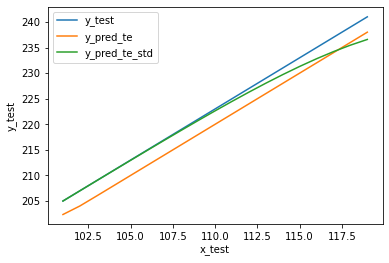

In [9]:
# linear dataset x and y = 2*x + 3
x = cp.arange(-100,100,1).reshape(200,1)
y = cp.array(2*x + 3).reshape(200,1)
x_test = cp.arange(101,120,1).reshape(19,1)
y_test = cp.array(2*x_test + 3).reshape(19,1)

compare(x, y, x_test, y_test)


RSME for y_error_tr is: 1.2880861948230199e-08
RSME for y_error_te is: 0.2873845184511081
RSME for y_error_tr_std is: 5.414038475886103e-07
RSME for y_error_te_std is: 0.046879150871525326


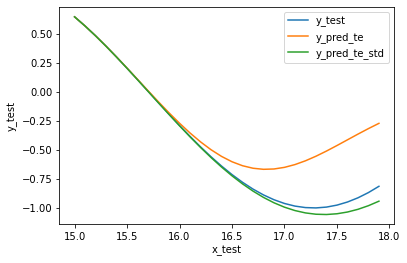

In [11]:
# sin dataset of x and y=sin(x)
x = cp.arange(-15,15,0.1)
n = x.shape[0]
x = x.reshape(n,1)
y = cp.array(cp.sin(x)).reshape(n,1)
dy = cp.array(cp.cos(x)).reshape(n,1)

x_test = cp.arange(15,18,0.1)
m = x_test.shape[0]
x_test = x_test.reshape(m,1)
y_test = cp.array(cp.sin(x_test)).reshape(m,1)
dy_text = cp.array(cp.cos(x_test)).reshape(m,1)

compare(x, y, x_test, y_test)

RSME for y_error_tr is: 8.155906639674947e-11
RSME for y_error_te is: 346.91361784157
RSME for y_error_tr_std is: 3.3487840727871555e-08
RSME for y_error_te_std is: 298.5913041293203


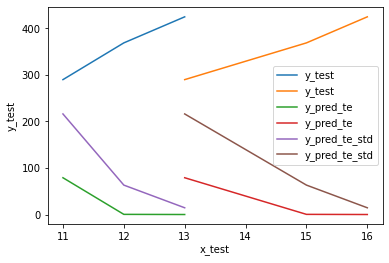

In [12]:
# d=2 and y = x[0]^2 + x[1]^2
x = cp.array([[0,2],[1,3],[2,4],[3,5],[4,6],[5,7],[6,8],[7,9],[8,10],[9,11],[10,12]])
y = cp.array(x[:,0]**2 + x[:,1]**2)
dy = cp.column_stack((2*x[:,0], 2*x[:,1]))

x_test = cp.array([[11,13],[12,15],[13,16]])
y_test = cp.array(x_test[:,0]**2 + x_test[:,1]**2)
dy_test = cp.column_stack((2*x_test[:,0], 2*x_test[:,1]))

compare(x, y, x_test, y_test)

UCI wine dataset shape is: (178, 14)
RSME for y_error_tr is: 7.10760626217028e-10
RSME for y_error_te is: 733.8428388652788
RSME for y_error_tr_std is: 1.0280782653322807e-07
RSME for y_error_te_std is: 319.29969716672315


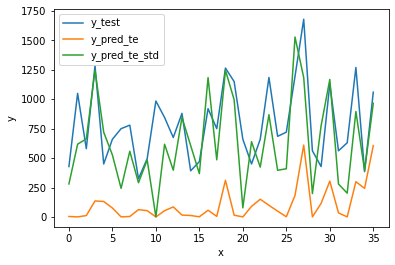

In [17]:
import numpy as np

# Load the wine dataset from UCI (replace the URL with the actual URL of the dataset)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
data = np.genfromtxt(url, delimiter=',')
print('UCI wine dataset shape is: ' + str(data.shape))

x_all = data[:,:-1]
y_all = data[:,-1]

x, x_test, y, y_test = train_test_split(x_all, y_all, test_size=0.2)

gr.fit(cp.array(x),cp.array(y))
y_pred_tr, cov_, std_ = gr.predict(cp.array(x))
y_pred_te, cov, std = gr.predict(cp.array(x_test))

gp_std.fit(x, y)
y_pred_tr_std = gp_std.predict(x)
y_pred_te_std = gp_std.predict(x_test)

y_error_tr = RMSE(cp.array(y), cp.array(y_pred_tr))
y_error_te = RMSE(cp.array(y_test), cp.array(y_pred_te))
y_error_tr_std = RMSE(cp.array(y), cp.array(y_pred_tr_std))
y_error_te_std = RMSE(cp.array(y_test), cp.array(y_pred_te_std))

print('RSME for y_error_tr is: ' + str(y_error_tr))
print('RSME for y_error_te is: ' + str(y_error_te))
print('RSME for y_error_tr_std is: ' + str(y_error_tr_std))
print('RSME for y_error_te_std is: ' + str(y_error_te_std))

# Plot the lines
plt.plot(y_test, label='y_test')
plt.plot(y_pred_te.get(), label='y_pred_te')
plt.plot(y_pred_te_std, label='y_pred_te_std')

# Add legend and labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()
